# DNA Nanodevice GNN Demo
This demo will show how to use the G3NAT (Graph Neural Network Nucleic Acid Transport) package to create a DNA Nanodevice as a graph and use it to train a graph neural network (GNN) 

In [1]:
# Pytorch moduels
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
import torch

#G3NAT Modules
from dataset import sequence_to_graph
from models import DNATransportGNN, train_model, train_model_with_custom_batching
from data_generator import create_sample_data, getTransmissionDOS
from visualize_dna_graph import visualize_dna_graph

# Other Python modules
import numpy as np
import matplotlib.pyplot as plt

# Part 1: Graph generation
Let's start with a test case: Double stranded DNA with two tails connected to contacts

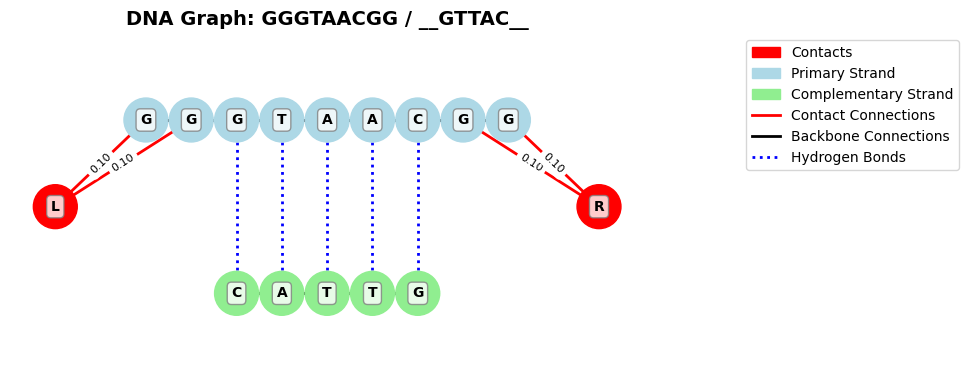

In [17]:
sequence = "GGGTAACGG"
complement = "__GTTAC__"
    
# Simple case: left contact at first position, right contact at last position
graph = sequence_to_graph(
    sequence,
    complement,
    left_contact_positions=[0,1],  # Connect to first bases (AC)
    right_contact_positions=[len(sequence)-2,len(sequence)-1],  # Connect to last bases (GT)
    left_contact_coupling=0.1,
    right_contact_coupling=0.1
)
fig, ax = visualize_dna_graph(graph, sequence, complement, figsize=(10,4))
plt.show()

Now we can use the built in functions to generate density of states (DOS) and coherent transmission with from the tight-binding model

Text(0.5, 0, '$E-E_{HOMO}$ eV')

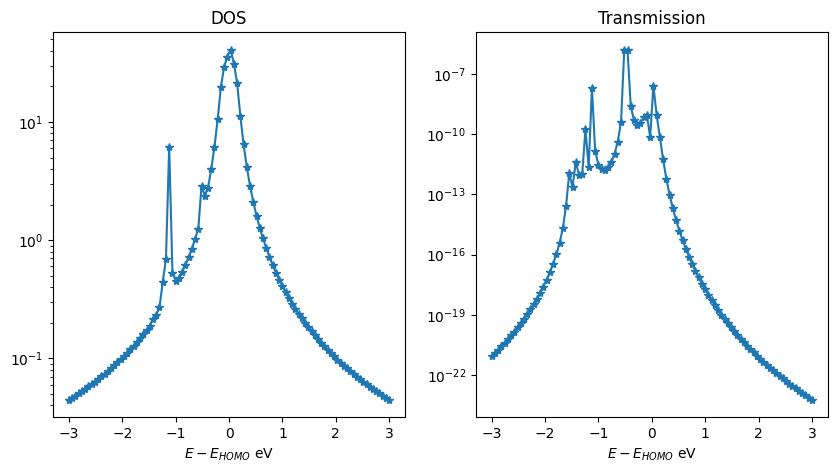

In [18]:
energy_grid=np.linspace(-3,3,100)

# Set up contacts:
gammaL = np.zeros(2*len(sequence))
gammaL[0] = 0.2
gammaL[1] = 0.2
gammaR = np.zeros(2*len(sequence))
gammaR[len(sequence)-2] = 0.2
gammaR[len(sequence)-1] = 0.2

#Get DOS/Transmission
T, dos = getTransmissionDOS(sequence, complement, energy_grid, gammaL, gammaR)
fix, (ax1, ax2)= plt.subplots(1,2, figsize=(10,5))
ax1.semilogy(energy_grid, dos, '*-')
ax1.set_title('DOS')
ax1.set_xlabel(r'$E-E_{HOMO}$ eV')
ax2.semilogy(energy_grid, T, '*-')
ax2.set_title('Transmission')
ax2.set_xlabel(r'$E-E_{HOMO}$ eV')

# Part 2: Using Pre-trained Model
Let's use our already generated model to see how well it works:

Loading model from: ./outputs/dna_transport_model.pth
Using device: cpu
Model loaded successfully!
Model parameters: 99,272
Energy grid: 100 points from -3.00 to 3.00 eV
Predicting for sequence: GGGTAACGG
Left contact at position [0, 1], coupling: 0.2
Right contact at position [6, 7], coupling: 0.2
Prediction completed!
DOS range: [-23.8173, -6.6135]
Transmission range: [-2.0214, 1.5589]


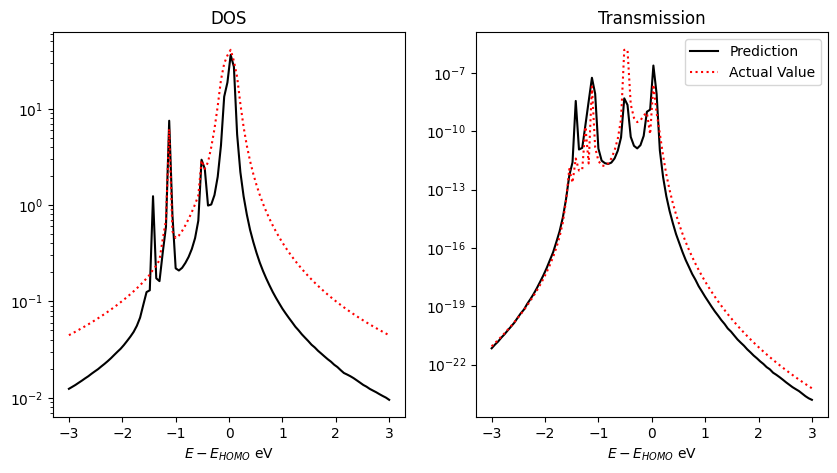

In [ ]:
# Or import and use
from models import load_trained_model, predict_sequence

# Load model
model, energy_grid, device = load_trained_model("./outputs/dna_transport_model.pth")

# Predict single sequence
trans_pred, dos_pred = predict_sequence(
    model, 
    sequence, 
    complement,
    energy_grid, 
    torch.device('cpu'),
    left_contact_positions=[0,1],  # Connect to first bases (AC)
    right_contact_positions=[6,7],  # Connect to last bases (GT)
    left_contact_coupling=0.2,
    right_contact_coupling=0.2
)

fix, (ax1, ax2)= plt.subplots(1,2, figsize=(10,5))
ax1.semilogy(energy_grid, 10**dos_pred, '-k', energy_grid, dos, ':r')
ax1.set_title('DOS')
ax1.set_xlabel(r'$E-E_{HOMO}$ eV')
ax2.legend(['Prediction', 'Actual Value'])
ax2.semilogy(energy_grid, 10**trans_pred, '-k', energy_grid, T, ':r')
ax2.set_title('Transmission')
ax2.set_xlabel(r'$E-E_{HOMO}$ eV')
ax2.legend(['Prediction', 'Actual Value'])